# Building a Convolutional Neural Network with NumPy

This notebook demonstrates the building of a Convolutional Neural Network (CNN) from scratch using only NumPy. We aim to understand each component and step involved in a CNN by manually implementing and visualizing them.

## Learning Objectives

1. Understand the mechanics behind convolutional, pooling, and fully connected layers.
2. Implement these layers from scratch using NumPy.
3. Visualize the intermediate outputs to gain insight into the network's operation.
4. Train a simple CNN on the MNIST dataset and evaluate its performance.


In [20]:
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Helper function to display images
def plot_images(images, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    for i, ax in enumerate(axes.flat):
        if images[i].shape == (28, 28):
            ax.imshow(images[i], cmap='binary')
        else:
            ax.imshow(images[i].reshape(28, 28), cmap='binary')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

## Dataset Preparation

We will use the MNIST dataset for this exercise. MNIST contains 70,000 images of hand-written digits, each of which is 28x28 pixels. Each image is labeled with the digit it represents. For our purposes, we will simplify the dataset to work with a smaller subset for quicker computation.

### Objectives:
1. Load the dataset.
2. Visualize the dataset.
3. Normalize the data for use in our network.
4. Reshape the images for convolution operations.

### Why Normalize?
Normalization is a crucial preprocessing step in the field of machine learning. For image data, normalization typically involves scaling the pixel values from the range of 0-255 to a range of 0-1. This scaling helps in a few ways:

- **Faster Convergence**: Networks train faster when the input data ranges are small. Normalizing the data to a [0,1] range means weights can also stay in a smaller and more manageable range, which accelerates the training process by improving the numerical stability of the calculations.
- **Consistent Input Distribution**: Normalizing ensures that all input features (pixels, in this case) have a consistent distribution. This is important because large differences in the range of input values can lead to issues where some weights update faster than others, which can destabilize the learning process.
- **Improves Gradient Flow**: During training, well-scaled features help maintain a healthy gradient flow in the deeper parts of the network, avoiding issues like the vanishing gradient problem, which is common with inputs that have vastly varying scales.

By standardizing our images to have pixel values between 0 and 1, we ensure our model learns more efficiently and is less likely to be biased toward features simply because they are scaled differently.


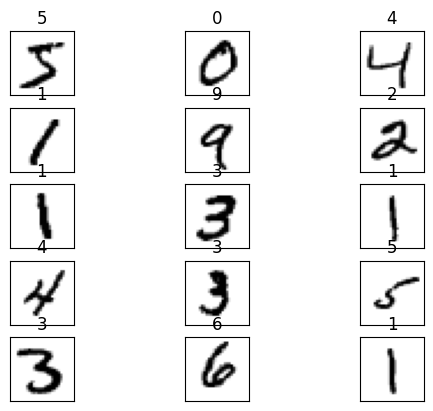

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Convert the data to numpy arrays and normalize
X = X.to_numpy().astype(np.float32) / 255.0
y = y.to_numpy().astype(int)

# Reshape the data to (n_samples, 28, 28, 1) for a single channel image
X = X.reshape((-1, 28, 28, 1))

# Display some images
plot_images(X[:15], y[:15], 5, 3)

# Split the dataset into training and testing sets
train_samples = 60000
X_train, X_test = X[:train_samples], X[train_samples:]
y_train, y_test = y[:train_samples], y[train_samples:]


## Implementing the Convolutional Layer

A convolutional layer applies a set of filters to the input. Each filter produces a feature map that emphasizes certain features present in the input. In this section, we'll manually implement a simple convolutional layer using NumPy to understand its operation.

### Concepts to Understand:
- **Filter**: A small matrix used to apply effects like blurring, sharpening, and edge detection. Each filter slides over the image to produce a feature map.
- **Stride**: The number of pixels we skip as we are sliding the filter across the image. A stride of 1 means the filter moves one pixel at a time.
- **Padding**: Adding pixels around the image border. Padding allows the filter to be applied to the bordering elements of the input image matrix.

### Objective:
Implement a function for a convolutional operation that includes settings for different strides and padding.


(28, 28)


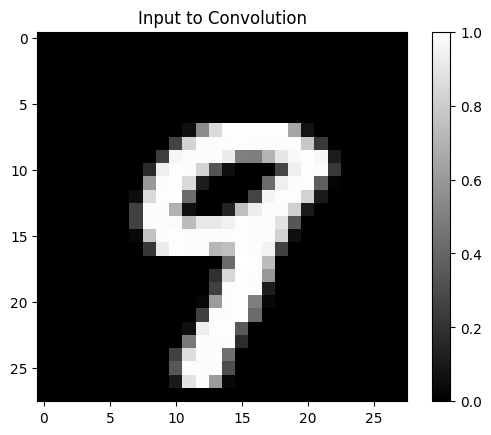

(28, 28)


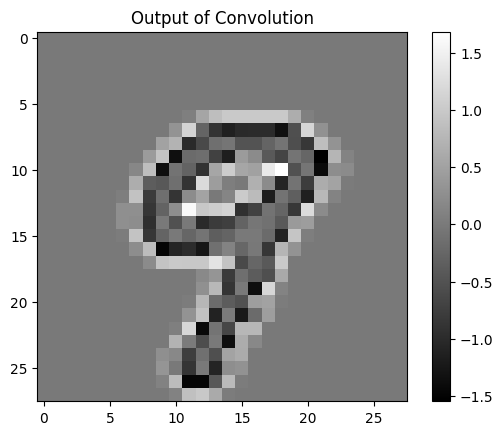

In [3]:
import numpy as np

def convolve2d(image, kernel, stride=1, padding=0):
    """
    Apply a 2D convolution operation to an image using a given kernel (filter).
    
    Args:
    - image (numpy array): The input image.
    - kernel (numpy array): The convolution filter.
    - stride (int): The number of pixels to move across the image.
    - padding (int): The number of pixels to pad around the input image.

    Returns:
    - numpy array: The convolved image (feature map).
    """
    # Add padding to the input image
    image_padded = np.pad(image, ((padding, padding), (padding, padding)), mode='constant')
    kernel_height, kernel_width = kernel.shape
    padded_height, padded_width = image_padded.shape

    # Determine the output dimensions
    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1
    output = np.zeros((output_height, output_width))

    # Perform the convolution operation
    for y in range(0, output_height):
        for x in range(0, output_width):
            x_start = x * stride
            y_start = y * stride
            x_end = x_start + kernel_width
            y_end = y_start + kernel_height
            output[y, x] = np.sum(image_padded[y_start:y_end, x_start:x_end] * kernel)

    return output

# Applying the convolution operation
kernel_example = np.array([[0, 1, 0],
                           [1, -4, 1],
                           [0, 1, 0]])
# image_example = np.random.rand(28, 28)  # Random image
image_example = X_train[random.randint(0, len(X_train) - 1)].reshape(28, 28) 

output_image = convolve2d(image_example, kernel_example, stride=1, padding=1)

# Visualize the input
print (image_example.shape)
plt.imshow(image_example, cmap='gray')
plt.title('Input to Convolution')
plt.colorbar()
plt.show()

# Visualize the result
print (output_image.shape)
plt.imshow(output_image, cmap='gray')
plt.title('Output of Convolution')
plt.colorbar()
plt.show()

## Implementing the ReLU Activation Function

After a convolution operation, it is common to apply an activation function to introduce non-linearity into the model. The ReLU (Rectified Linear Unit) function is one of the most commonly used activation functions in deep learning models, especially in CNNs. It is defined as:

\[ f(x) = max(0, x) \]

### Objective:
Implement the ReLU function and apply it to the output of our convolution layer to create the activation map.

### Benefits of ReLU:
- **Efficiency**: ReLU is computationally efficient because it involves simpler mathematical operations.
- **Sparsity**: By turning all negative values to zero, it leads to sparse representations, which are beneficial for neural networks in terms of efficiency and performance.
- **Mitigating Vanishing Gradient Problem**: ReLU helps in mitigating the vanishing gradient problem, which is a common issue in deep networks where gradients become too small for effective learning.


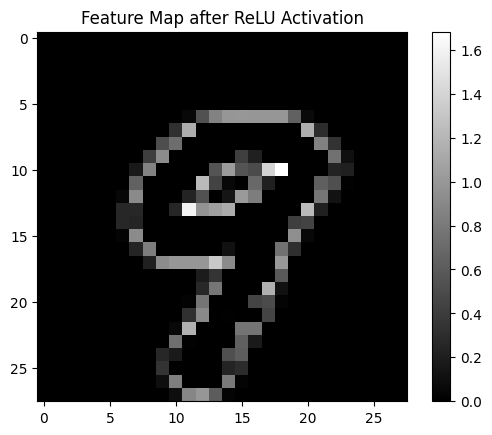

In [4]:
def relu_activation(feature_map):
    """
    Apply ReLU activation function to the feature map.
    
    Args:
    - feature_map (numpy array): Output from the convolution layer.

    Returns:
    - numpy array: Activated feature map where all negative values are set to zero.
    """
    return np.maximum(0, feature_map)

# Apply ReLU to the output of the convolution
activated_feature_map = relu_activation(output_image)

# Visualize the activated feature map
plt.imshow(activated_feature_map, cmap='gray')
plt.title('Feature Map after ReLU Activation')
plt.colorbar()
plt.show()


## Implementing the Pooling Layer

Pooling layers serve to down-sample the feature maps obtained from the convolutional layers. Among the pooling techniques, max pooling is the most popular. It operates by sliding a window across the feature map and selecting the maximum value from each window. This helps to make the detection of features invariant to scale and orientation changes.

### Objective:
Implement max pooling to reduce the spatial dimensions of the input feature map.

### Benefits of Max Pooling:
- **Reduces Computational Load**: By decreasing the feature map dimensions, it reduces the number of parameters and computations needed in the network, speeding up the learning process.
- **Controls Overfitting**: Pooling helps in abstracting the features and thus reduces the risk of overfitting by providing an abstracted form of the features.
- **Translation Invariance**: Max pooling provides a form of translation invariance, as the exact location of the features becomes less important than their rough location relative to other features.


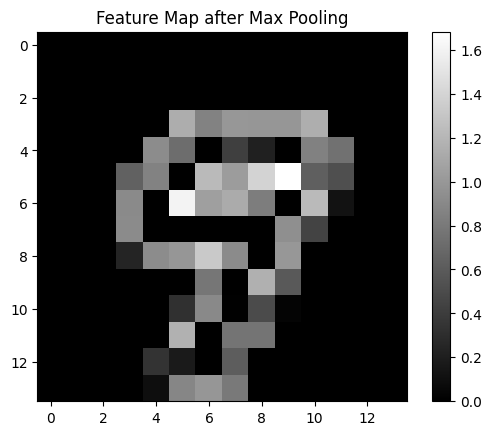

In [5]:
def max_pooling(feature_map, size=2, stride=2):
    """
    Apply max pooling operation to reduce the size of the feature map.
    
    Args:
    - feature_map (numpy array): The feature map from a convolutional or activation layer.
    - size (int): The size of the window to take max over.
    - stride (int): The stride or step to move the window across the feature map.

    Returns:
    - numpy array: Down-sampled feature map.
    """
    # Dimensions of the input feature map
    height, width = feature_map.shape
    # Dimensions of the output feature map
    pooled_height = (height - size) // stride + 1
    pooled_width = (width - size) // stride + 1
    pooled_feature_map = np.zeros((pooled_height, pooled_width))

    for i in range(pooled_height):
        for j in range(pooled_width):
            h_start = i * stride
            w_start = j * stride
            h_end = h_start + size
            w_end = w_start + size
            # Applying the pooling operation
            pooled_feature_map[i, j] = np.max(feature_map[h_start:h_end, w_start:w_end])
    
    return pooled_feature_map

# Apply max pooling to the activated feature map
pooled_feature_map = max_pooling(activated_feature_map)

# Visualize the pooled feature map
plt.imshow(pooled_feature_map, cmap='gray')
plt.title('Feature Map after Max Pooling')
plt.colorbar()
plt.show()


## Fully Connected Layer and Training Setup

After processing through convolutional and pooling layers, the output must be flattened and fed into a fully connected layer. This layer combines all the features to make final predictions. Additionally, we'll implement a simple loss function and a training loop to update our weights.

### Objectives:
1. Implement a simple fully connected layer.
2. Introduce a basic loss function for measuring training performance.
3. Create a training loop to adjust our model weights based on the loss.

### Importance of Fully Connected Layer:
- **Decision Making**: The fully connected layer is where the network makes decisions based on the features extracted by the conv and pooling layers.
- **Learning Non-linear Combinations of Features**: While convolutional layers handle feature detection, fully connected layers learn non-linear combinations of these features, crucial for classification.


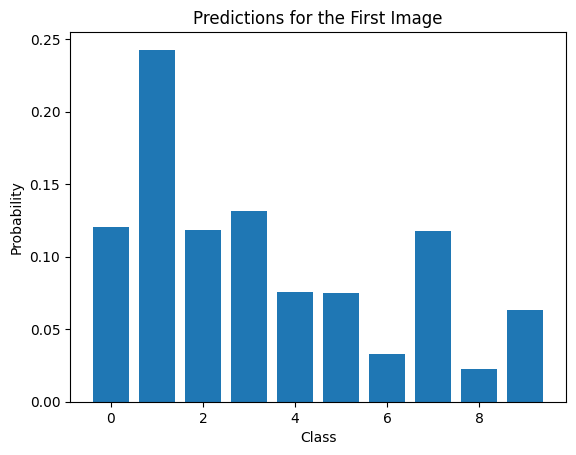

Loss: 2.590353001283406


In [6]:
def initialize_weights(shape):
    """
    Initialize weights with a small random value using the normal distribution.
    """
    return np.random.normal(loc=0.0, scale=0.1, size=shape)

def fully_connected(input_layer, weights):
    """
    Apply a fully connected layer to the input layer with the given weights.
    """
    return np.dot(input_layer, weights)

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)  # only difference

def cross_entropy_loss(predictions, labels):
    """
    Compute the cross-entropy loss between predictions and labels.
    """
    return -np.sum(labels * np.log(predictions))

# Initialize weights for the fully connected layer
fc_weights = initialize_weights((pooled_feature_map.size, 10))  # assuming 10 classes

# Flatten the pooled feature map
flattened_features = pooled_feature_map.flatten()

# Fully connected layer
fc_output = fully_connected(flattened_features, fc_weights)

# Softmax activation for classification
predictions = softmax(fc_output)

# Example labels (one-hot encoded for 10 classes)
labels = np.zeros(10)
labels[y_train[0]] = 1  # Assuming y_train[0] is the correct label for the first image

# Calculate loss
loss = cross_entropy_loss(predictions, labels)

# Visualize predictions
plt.bar(range(10), predictions)
plt.title('Predictions for the First Image')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.show()

print("Loss:", loss)


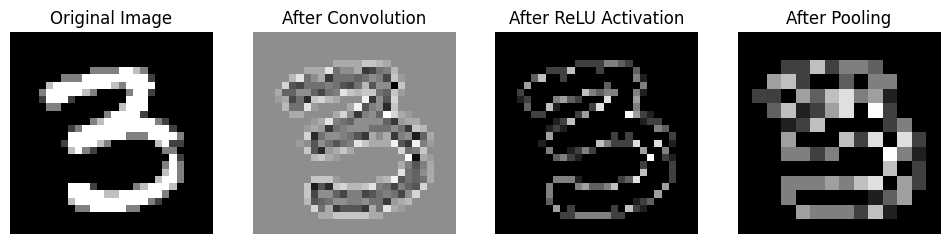

In [7]:
def display_image_transformations(image_index):
    """
    Display the original image and its transformations through the CNN layers.

    Args:
    - image_index (int): Index of the image in the dataset to display.
    """
    original_image = X_train[image_index].reshape(28, 28)  # Reshape to 2D image

    # Apply convolution
    convolved_image = convolve2d(original_image, kernel_example, stride=1, padding=1)
    
    # Apply ReLU activation
    activated_image = relu_activation(convolved_image)
    
    # Apply max pooling
    pooled_image = max_pooling(activated_image, size=2, stride=2)

    # Plotting all the images
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    axs[0].imshow(original_image, cmap='gray')
    axs[0].title.set_text('Original Image')
    axs[0].axis('off')

    axs[1].imshow(convolved_image, cmap='gray')
    axs[1].title.set_text('After Convolution')
    axs[1].axis('off')

    axs[2].imshow(activated_image, cmap='gray')
    axs[2].title.set_text('After ReLU Activation')
    axs[2].axis('off')

    axs[3].imshow(pooled_image, cmap='gray')
    axs[3].title.set_text('After Pooling')
    axs[3].axis('off')

    plt.show()

# Select a random image index
random_index = random.randint(0, len(X_train) - 1)

# Display the transformations for the selected image
display_image_transformations(random_index)


## Implementing the Training Loop

Now that we have implemented all parts of our simple CNN, the next step is to create a training loop. The training loop will allow us to iteratively update the weights of our network to reduce the loss, thus training our model to better classify the images.

### Training Steps:
1. Forward pass: Run the network forward to compute the output.
2. Compute loss: Calculate the loss (how far the output is from the truth).
3. Backward pass: Compute the gradient of the loss with respect to each weight.
4. Update weights: Adjust the weights by a small fraction of the computed gradients to reduce the loss.

### Gradient Descent:
- **Learning Rate**: Determines how big a step we take on each iteration. If too large, it might overshoot the minimum; if too small, training may be too slow.
- **Epochs**: One epoch is a full iteration over the entire training dataset. We'll run multiple epochs to improve accuracy.


In [15]:
def train_simple_cnn(X_train, y_train, epochs, learning_rate):
    global fc_weights  # Use the global variable for simplicity

    for epoch in range(epochs):
        total_loss = 0

        for i in range(len(X_train)):
            # Forward pass (simplified for a single example)
            image = X_train[i].reshape(28, 28)
            convolved = convolve2d(image, kernel_example, stride=1, padding=1)
            activated = relu_activation(convolved)
            pooled = max_pooling(activated, size=2, stride=2)
            flattened = pooled.flatten()
            output = fully_connected(flattened, fc_weights)
            predicted = softmax(output)
            
            # Compute loss (using cross-entropy and assuming one-hot encoding)
            true_label = np.zeros(10)
            true_label[y_train[i]] = 1
            loss = cross_entropy_loss(predicted, true_label)
            total_loss += loss
            
            # Backward pass (gradient calculation - highly simplified)
            # Reshape predicted - true_label to match the dot product requirements
            gradient = np.outer(flattened, (predicted - true_label))
            # Update weights
            fc_weights -= learning_rate * gradient

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(X_train)}")

# Example call to the training function
train_simple_cnn(X_train[:5000], y_train[:5000], epochs=10, learning_rate=0.01)
# train_simple_cnn(X_train, y_train, epochs=10, learning_rate=0.01)


Epoch 1, Loss: 0.5434770541659459
Epoch 2, Loss: 0.511466302470034
Epoch 3, Loss: 0.49505431822170615
Epoch 4, Loss: 0.4839764041468602
Epoch 5, Loss: 0.47560540144274555
Epoch 6, Loss: 0.46886203533728976
Epoch 7, Loss: 0.4632050896405707
Epoch 8, Loss: 0.45832717702040215
Epoch 9, Loss: 0.45403742706215505
Epoch 10, Loss: 0.4502090507725197


In [18]:
# Assuming `fc_weights` is the variable holding your trained weights
weights_to_save = {
    'fc_weights': fc_weights
}

# Save to a file
with open('cnn_model_weights.pkl', 'wb') as file:
    pickle.dump(weights_to_save, file)

print("Model weights saved successfully!")


Model weights saved successfully!


In [21]:
# Load the weights from the file
with open('cnn_model_weights.pkl', 'rb') as file:
    loaded_weights = pickle.load(file)

# Extract the weights to use in predictions
fc_weights = loaded_weights['fc_weights']

print("Model weights loaded successfully!")


Model weights loaded successfully!


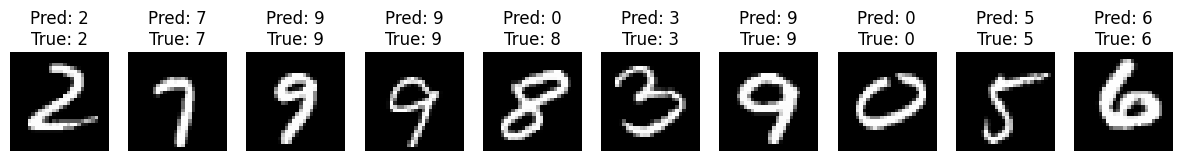

In [22]:
def predict_with_cnn(image, weights):
    # Apply the same layers as in the training
    convolved = convolve2d(image, kernel_example, stride=1, padding=1)
    activated = relu_activation(convolved)
    pooled = max_pooling(activated, size=2, stride=2)
    flattened = pooled.flatten()
    output = fully_connected(flattened, weights)
    return softmax(output)

def visualize_predictions(X_test, y_test, weights, num_images=10):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 1.5))
    for i, ax in enumerate(axs):
        index = np.random.randint(0, len(X_test))  # Random index for test image
        image = X_test[index].reshape(28, 28)
        predicted_probabilities = predict_with_cnn(image, weights)
        predicted_label = np.argmax(predicted_probabilities)

        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Pred: {predicted_label}\nTrue: {y_test[index]}")

    plt.show()

# Now call the function to visualize the predictions
visualize_predictions(X_test, y_test, fc_weights, num_images=10)
